In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

import os
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import time


training_path = "fruits-360_dataset/Training"
test_path = "fruits-360_dataset/Test"

try:
    STATS = np.load("stats.npy", allow_pickle=True)
except FileNotFoundError as fnf:
    print("Not found stats file.")
    STATS = []

# Parameters    
GRAY_SCALE = False
FRUITS = os.listdir(training_path)

random.shuffle(FRUITS)
train_load = 0.15
test_load = 0.15

model_name = f"fruits-15%-with-98stop-validation-{len(FRUITS)}-{time.time():10.0f}"
print(f"Model name '{model_name}'")

tensorboard = TensorBoard(log_dir=f'logs/{model_name}')

Not found stats file.
Model name 'fruits-15%-with-98stop-validation-120-1586813330'


In [2]:
def load_data(directory_path, load_factor=None):
    data = []
    labels = []
               
            
    for fruit_name in FRUITS:
        class_num = FRUITS.index(fruit_name)                
        
        path = os.path.join(directory_path, fruit_name)
        
        for img in os.listdir(path):
            if load_factor and np.random.random() > load_factor:  # skip image
                continue
                
            img_path = os.path.join(path, img)    
            if GRAY_SCALE:
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                image = cv2.imread(img_path)
                image = image[:, :, [2, 1, 0]]
                
#             image = tf.keras.utils.normalize(image)  # This is normalizes 0 to gray color
            image = image / 255.0
            data.append([image, class_num])

    random.shuffle(data)
        
    X = []
    y = []
    
    
    for image, label in data:
        X.append(image)
        y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    
    if GRAY_SCALE:
        print("Reshaping gray scale")
        X = X.reshape(-1, X.shape[1], X.shape[2], 1)
        
    return X, y      

In [3]:
X_training, y_training = load_data(training_path, load_factor=train_load)
print("Created training array")    
print(f"X shape: {X_training.shape}")
print(f"y shape: {y_training.shape}")

Created training array
X shape: (8911, 100, 100, 3)
y shape: (8911,)


In [4]:
X_test, y_test = load_data(test_path, load_factor=test_load)

print("Created test arrays")    
print(f"X shape: {X_test.shape}")
print(f"y shape: {y_test.shape}")

Created test arrays
X shape: (3105, 100, 100, 3)
y shape: (3105,)


In [5]:
class AfterTwoEpochStop(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
#         super(AfterTwoEpochStop, self).__init__()
        self.threshold = threshold
        self.checked = False
        print("Init")

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]        
        if val_acc >= self.threshold:
            if self.checked:
                self.model.stop_training = True
            else:
                self.checked = True
        else:
            self.checked = False

stop = AfterTwoEpochStop(0.98)                

Init


In [6]:
# Limit gpu memory usage
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = False
config.gpu_options.per_process_gpu_memory_fraction = 0.25
sess = tf.compat.v1.Session(config=config)

In [7]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Activation, Dropout

pic_shape = X_training.shape[1:]
label_count = len(FRUITS)

print(f"Pic shape: {pic_shape}")

# Input
model = tf.keras.models.Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=pic_shape),
    MaxPooling2D(pool_size=(2, 2)),
    
#     Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Dropout(0.25),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(label_count, activation='softmax')    
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Pic shape: (100, 100, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (N

In [8]:
history = model.fit(X_training, y_training, 
                             batch_size=25, epochs=15,
                             validation_data=(X_test, y_test),
                             callbacks=[tensorboard, stop])

Train on 8911 samples, validate on 3105 samples
Epoch 1/15
8911/8911 [==============================] - 9s 986us/sample - loss: 2.1246 - accuracy: 0.5050 - val_loss: 0.9861 - val_accuracy: 0.7349
Epoch 2/15
8911/8911 [==============================] - 7s 806us/sample - loss: 0.2652 - accuracy: 0.9220 - val_loss: 0.4644 - val_accuracy: 0.8905
Epoch 3/15
8911/8911 [==============================] - 7s 806us/sample - loss: 0.0903 - accuracy: 0.9741 - val_loss: 0.5991 - val_accuracy: 0.8538
Epoch 4/15
8911/8911 [==============================] - 7s 802us/sample - loss: 0.0943 - accuracy: 0.9731 - val_loss: 0.4923 - val_accuracy: 0.8915
Epoch 5/15
8911/8911 [==============================] - 7s 818us/sample - loss: 0.0469 - accuracy: 0.9871 - val_loss: 0.5574 - val_accuracy: 0.8853
Epoch 6/15
8911/8911 [==============================] - 7s 821us/sample - loss: 0.0773 - accuracy: 0.9756 - val_loss: 0.6335 - val_accuracy: 0.8779
Epoch 7/15
8911/8911 [==============================] - 8s 865us

In [13]:
loss = history.history['loss']
accuracy = history.history['accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

print(f"Test Accuracy: {accuracy[-1]:>2.4f}")
print(f"Test loss: {loss[-1]:>2.4f}")

Test Accuracy: 0.9873
Test loss: 0.0438


In [14]:
predictions = model.predict(X_test)

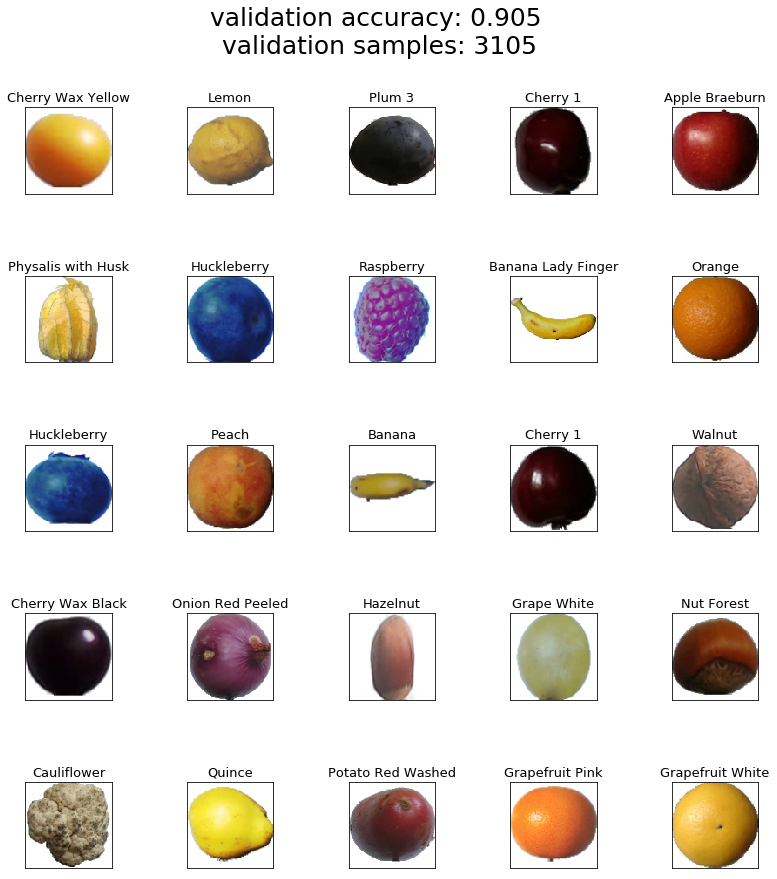

In [18]:
fig = plt.figure(figsize=(14, 14))
for x in range(1,26):
    class_num = np.argmax(predictions[x])
    valid = y_test[x] == class_num
    ax = fig.add_subplot(5, 5, x)
    ax.imshow(X_test[x])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    title = FRUITS[class_num] + ("\ninvalid classification" if not valid else "")
    ax.set_title(title, size=13)

last_val_accuracy = val_accuracy[-1]
    
fig.subplots_adjust(hspace=0.95)
fig.suptitle(f"validation accuracy: {last_val_accuracy:>2.3f} \nvalidation samples: {len(X_test)}", size=25)
fig.savefig("last-validation.png")
# fig.show()

Grapefruit-White


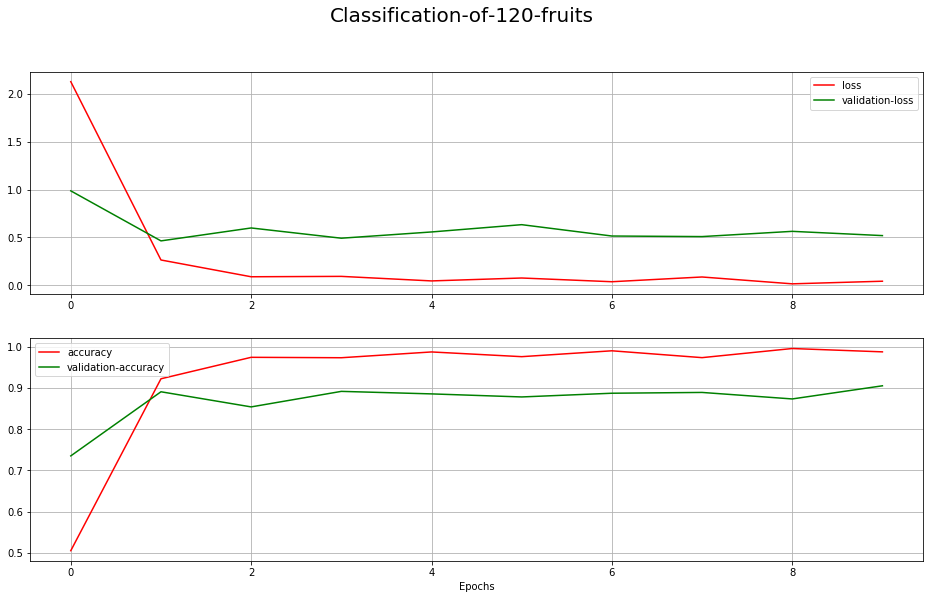

In [19]:
SMOOTH = False

epochs = history.epoch



# if SMOOTH:    
#     from scipy.interpolate import CubicSpline
#     cs_loss = CubicSpline(epochs, loss)
#     cs_acc = CubicSpline(epochs, acc)
    
#     x = np.linspace(0, epochs[-1], 100)
#     y_loss = cs_loss(x)
#     y_acc = cs_acc(x)

# else:
#     x = epochs
#     y_loss = loss
#     y_acc = acc
    
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(2,1,1)

plt.plot(loss, label='loss', c='r')
plt.plot(val_loss, label='validation-loss', c='g')
plt.legend(loc='best')
plt.grid()

plt.subplot(2,1,2)
plt.plot(accuracy, label='accuracy', c='r')
plt.plot(val_accuracy, label='validation-accuracy', c='g')
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.grid()

title = f"Classification of {len(FRUITS)} fruits".replace(' ', '-')
fig.suptitle(title, size=20)
pic_name = ax.get_title().replace(' ', '-')
print(pic_name)

plt.savefig(f"{title}.png")
plt.show()

In [20]:
# Free memory
# X_training = None
# y_training = None

# X_test = None
# y_test = None